In [1]:
## Notebook env: gedi (R kernel)
## GEDI pt.3 - runs GEDI to find spliced/unspliced ratio of genes across perturbations
## this notebook continues the analysis with sampling cells per guide to remove bias from high cell count guides

In [2]:
.libPaths('/home/ssobti/projects/mir_tud/packages/gedi_R_pkgs')

## install packages below into env if not already installed
## remotes::install_github('csglab/GEDI', lib = '/home/ssobti/projects/mir_tud/packages/gedi_R_pkgs')
seed_index = 3
seeds = c(123, 456, 789, 101112, 131415, 161718, 192021, 222324, 252627, 282930)
picked_seed = seeds[seed_index]

library(dplyr)
library(tidyr)
library(Seurat)
library(HDF5Array)
library(ggplot2)
library(Matrix)
library(RColorBrewer)
library(uwot)
library(GEDI)
library(SeuratWrappers)


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Loading required package: SeuratObject



Loading required package: sp




Attaching package: ‘SeuratObject’




The following object is masked from ‘package:base’:

    intersect




Loading required package: DelayedArray



Loading required package: stats4



Loading required package: Matrix




Attaching package: ‘Matrix’




The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Loading required package: BiocGenerics




Attaching package: ‘BiocGenerics’




The following object is masked from ‘package:SeuratObject’:

    intersect




The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union




The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs




The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min




Loading required package: MatrixGenerics



Loading required package: matrixStats




Attaching package: ‘matrixStats’




The following object is masked from ‘package:dplyr’:

    count





Attaching package: ‘MatrixGenerics’




The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    rowWeightedMads, rowWeightedMeans, rowWeightedMedians,
    rowWeightedSds, rowWeig

Loading required package: S4Vectors




Attaching package: ‘S4Vectors’




The following objects are masked from ‘package:Matrix’:

    expand, unname




The following object is masked from ‘package:tidyr’:

    expand




The following objects are masked from ‘package:dplyr’:

    first, rename




The following object is masked from ‘package:utils’:

    findMatches




The following objects are masked from ‘package:base’:

    expand.grid, I, unname




Loading required package: IRanges




Attaching package: ‘IRanges’




The following object is masked from ‘package:sp’:

    %over%




The following objects are masked from ‘package:dplyr’:

    collapse, desc, slice




Loading required package: S4Arrays



Loading required package: abind




Attaching package: ‘S4Arrays’




The following object is masked from ‘package:abind’:

    abind




The following object is masked from ‘package:base’:

    rowsum




Loading required package: SparseArray




Attaching package: ‘DelayedArray’




The following objects are masked from ‘package:base’:

    apply, scale, sweep




Loading required package: rhdf5




Attaching package: ‘HDF5Array’




The following object is masked from ‘package:rhdf5’:

    h5ls




In [3]:
model = readRDS('/home/ssobti/projects/mir_tud/output_data/splicing/tRF/tRF_gedi_model.rds')

In [4]:
## get RNA stability (spliced/unspliced counts) from gedi model -- imputedY (logt of psi values)
imputedY <- getY.gedi(model)
RNA_stability_mtx = imputedY
dim(RNA_stability_mtx)

[1]  5905 56074

### assign cells guide identity

In [5]:
## assign cells guide identity
tRF_seurat = readRDS('/home/ssobti/projects/mir_tud/101423_filtered_data/tRF.integrated.qc_norm_scaled.dimred.clustered.gex.guide_assigned.RDS')
meta = tRF_seurat@meta.data
meta$cell_names = paste(meta$sample, meta$barcode, sep = ':')
head(meta)

,orig.ident,nCount_RNA,nFeature_RNA,sample,barcode,guide,lor,pvalue,adj_pvalue,max_umi,⋯,m_umi,v_umi,log_max_umi,log_n_umi,log_m_umi,percent.mt,integrated_snn_res.0.5,seurat_clusters,guide_group,cell_names
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
tRF_1:AAACCCAAGGCCTTGC-1,tRF,20239,5372,tRF_1,AAACCCAAGGCCTTGC,TuD_NC_01,2.144148,1.652448e-15,8.377661e-09,23,⋯,0.1506849,2.458841,1.361728,1.518514,-0.82193017,6.363951,4,control,control,tRF_1:AAACCCAAGGCCTTGC
tRF_1:AAACCCACATATACCG-1,tRF,35201,7086,tRF_1,AAACCCACATATACCG,tRF_Arg_ACG_2,7.473168,2.865581e-322,1.452806e-315,182,⋯,0.9771689,151.260944,2.260071,2.330414,-0.01003034,6.295276,3,T3,target,tRF_1:AAACCCACATATACCG
tRF_1:AAACCCACATGACAGG-1,tRF,32207,6695,tRF_1,AAACCCACATGACAGG,TuD_NC_01,2.336330,3.615579e-22,1.833044e-15,36,⋯,0.2420091,5.973273,1.556303,1.724276,-0.61616825,6.237774,1,control,control,tRF_1:AAACCCACATGACAGG
tRF_1:AAACCCACATGACGGA-1,tRF,38017,7151,tRF_1,AAACCCACATGACGGA,tRF_Arg_ACG_2,1.160519,2.865581e-322,1.452806e-315,214,⋯,1.6986301,237.780319,2.330414,2.570543,0.23009883,6.831154,3,T3,target,tRF_1:AAACCCACATGACGGA
tRF_1:AAACCCAGTCAACCAT-1,tRF,28633,6505,tRF_1,AAACCCAGTCAACCAT,TuD_NC_01,3.011825,9.624496e-26,4.879475e-19,38,⋯,0.2328767,6.638180,1.579784,1.707570,-0.63287394,8.619425,4,control,control,tRF_1:AAACCCAGTCAACCAT
tRF_1:AAACCCAGTTATCTTC-1,tRF,28000,6688,tRF_1,AAACCCAGTTATCTTC,tRF_Glu_CTC_2,4.656560,7.086097e-135,3.592545e-128,69,⋯,0.4018265,21.984584,1.838849,1.944483,-0.39596144,6.617857,2,T2,target,tRF_1:AAACCCAGTTATCTTC


In [6]:
## clean up cell names in RNA_stability_mtx
RNA_stability_cell_names = stringr::str_sub(colnames(RNA_stability_mtx), start = 1, end = -2)
colnames(RNA_stability_mtx) = RNA_stability_cell_names

## filter out cells that were not confidentally assigned to a guide
RNA_stability_mtx = RNA_stability_mtx[, RNA_stability_cell_names %in% meta$cell_names]
RNA_stability_cell_names = colnames(RNA_stability_mtx)
dim(RNA_stability_mtx)

[1]  5905 23321

In [7]:
RNA_stability_cell_identity = data.frame(cell_names = RNA_stability_cell_names, guide = meta[match(RNA_stability_cell_names, meta$cell_names), 'guide'])
RNA_stability_cell_identity$guide = paste0(stringr::str_sub(RNA_stability_cell_identity$cell_names, 1, 6), RNA_stability_cell_identity$guide)
head(RNA_stability_cell_identity)

,cell_names,guide
,<chr>,<chr>
1,tRF_1:AAACGAACAGCACAAG,tRF_1:TuD_NC_01
2,tRF_1:AAACCCACATGACAGG,tRF_1:TuD_NC_01
3,tRF_1:AAACGCTCATTCGGGC,tRF_1:tRF_Ser_GCT_2
4,tRF_1:AAACGAAGTAGGACTG,tRF_1:tRF_Leu_TAG_2
5,tRF_1:AAACCCATCCTATGGA,tRF_1:TuD_NC_01
6,tRF_1:AAACGAAGTCACTTAG,tRF_1:TuD_NC_01


In [8]:
## sample 30 cells per guide, throw out guides with cells < 30
## combiine the three samples into one
set.seed(picked_seed)
fixed_cell_count = 30
RNA_stability_cell_identity$guide = stringr::str_sub(RNA_stability_cell_identity$guide, 7, -1)

## remove guides with less than 30 cells
table(RNA_stability_cell_identity$guide) %>% as.data.frame() %>% filter(Freq >= fixed_cell_count) -> guides_with_30_cells
RNA_stability_cell_identity = RNA_stability_cell_identity[RNA_stability_cell_identity$guide %in% guides_with_30_cells$Var1, ]

## sample 30 cells per guide
RNA_stability_cell_identity %>% group_by(guide) %>% sample_n(fixed_cell_count) -> sampled_RNA_stability_cell_identity
sampled_cells = sampled_RNA_stability_cell_identity$cell_names
RNA_stability_mtx = RNA_stability_mtx[, sampled_cells]

### create violin plots of RNA stability (spliced/unspliced counts) for top and bottom 5% of guides

In [9]:
## RNA_stability_mtx and RNA_stability_cell_identity are the two inputs for our analysis
guides = unique(RNA_stability_cell_identity$guide)


barcodes_per_guide = lapply(X = guides, FUN = function(x) {
  RNA_stability_cell_identity %>% filter(guide == x) %>% select(cell_names) %>% pull()
})

names(barcodes_per_guide) = guides

In [10]:
## use rowMedians??? if mostly zeros
RNA_stability_values = list()

for (i in 1:length(barcodes_per_guide)) {
  RNA_stability_values[[i]] = Matrix::rowMeans(RNA_stability_mtx[, colnames(RNA_stability_mtx) %in% barcodes_per_guide[[i]]])
}

names(RNA_stability_values) = names(barcodes_per_guide)

In [11]:
saveRDS(RNA_stability_values, paste0('/home/ssobti/projects/mir_tud/output_data/splicing/tRF/tRF_gedi_stability_values_seed_', seed_index, '.rds'))

In [12]:
## find top 1% and bottom 1% of guides by median of genes in each guide
medians = lapply(RNA_stability_values, median)
bottom = names(medians[as.numeric(medians) < quantile(as.numeric(medians), probs = 0.01)])
top = names(medians[as.numeric(medians) > quantile(as.numeric(medians), probs = 0.99)])
displayed_guides = c(bottom, top)

In [13]:
violin_df = do.call(cbind, RNA_stability_values[displayed_guides])
violin_df = as.data.frame(violin_df) %>% pivot_longer(cols = everything(), names_to = 'guide', values_to = 'RNA_stability')
ordered_guides = violin_df %>% group_by(guide) %>% summarize(median = median(RNA_stability), .groups = 'drop') %>% arrange(median) %>% pull(guide)
violin_df$guide = factor(violin_df$guide, levels = ordered_guides)

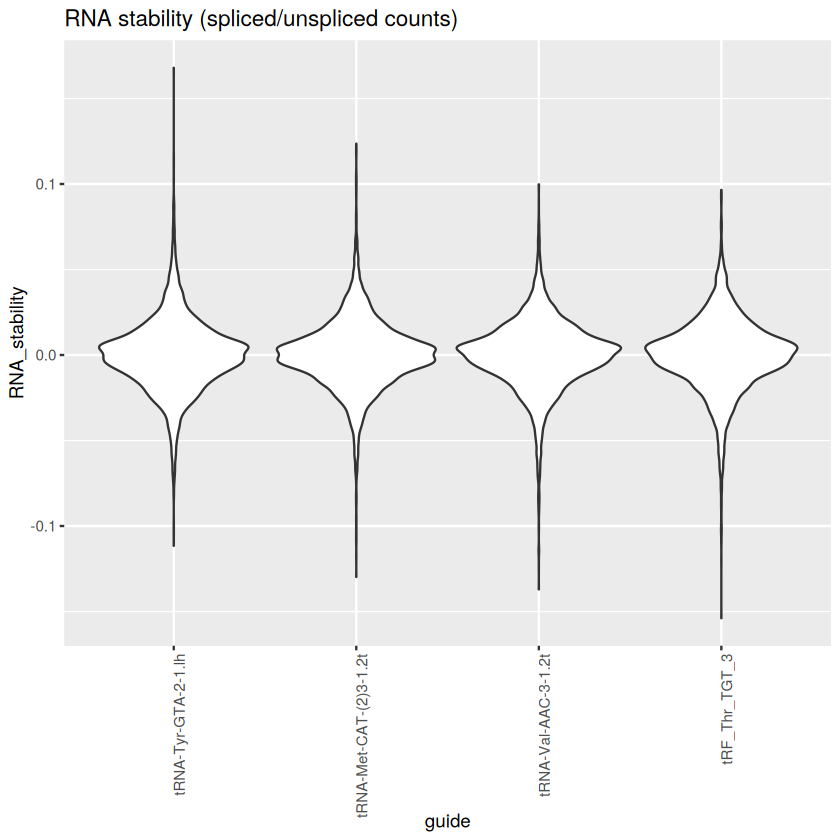

In [14]:
violin_df %>% ggplot(aes(x = guide, y = RNA_stability)) + geom_violin() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + ggtitle('RNA stability (spliced/unspliced counts)')